In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_json('../train.json')

What is the size of the data (number of rows and columns)?

In [3]:
# size (rows, columns)
df.shape

(49352, 15)

List of columns. Which column is the target?

In [4]:
# columns
df.columns.tolist()

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level']

The target is price.

I'm doing a quick data analysis using the info(), describe(), corr() methods. Are there any empty columns?

In [5]:
print ('Base info:')
df.info()

print('Statistics of numerical columns:')
print(df.describe())

print('Empty values:')
print(df.isnull().sum())

print('Correlation matrix:')
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(df[numeric_columns].corr())

Base info:
<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB
Statistics of numerical columns:
       

There are NO empty columns.

I'm working with only three features: 'bathrooms', 'bedrooms', 'interest_level' and the target column 'price'. I'm creating a dataframe containing only these columns.

In [6]:
features_df = df[['bathrooms', 'bedrooms', 'interest_level', 'price']]
features_df.head()

,bathrooms,bedrooms,interest_level,price
4,1.0,1,medium,2400
6,1.0,2,low,3800
9,1.0,2,medium,3495
10,1.5,3,medium,3000
15,1.0,0,low,2795


I'm trying to build a histogram to understand the distribution of the target.

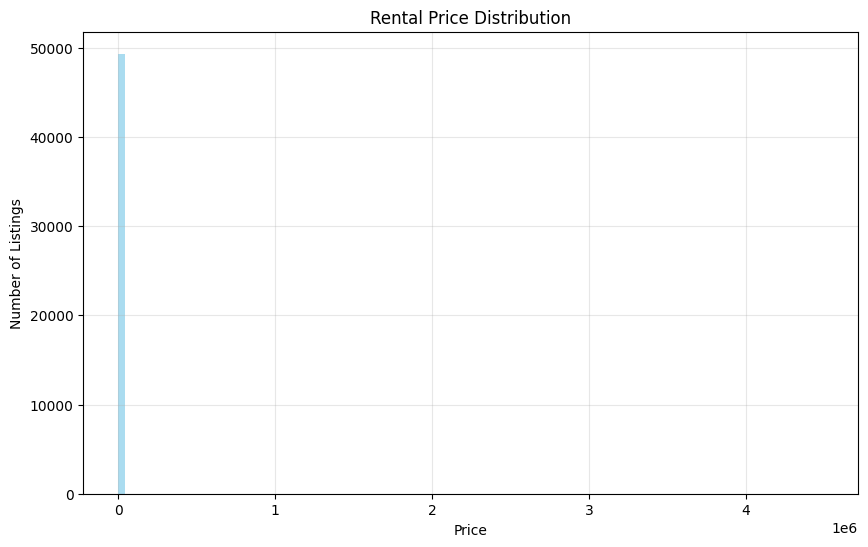

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(features_df['price'], bins=100, alpha=0.7, color='skyblue')
plt.title('Rental Price Distribution')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.grid(True, alpha=0.3)
plt.show()

It's unclear.

Problem: the data is concentrated in a very narrow range (2000-5000) and merges into one bar (because there are many listings). Everything is stuck together.

Next step - boxplot().

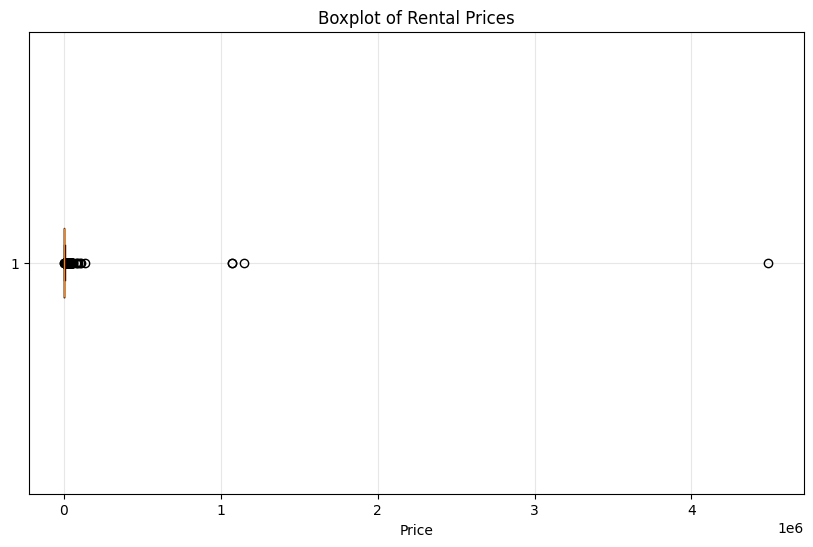

In [8]:
plt.figure(figsize=(10, 6))
plt.boxplot(features_df['price'], vert=False)

plt.title('Boxplot of Rental Prices')
plt.xlabel('Price')
plt.grid(True, alpha=0.3)
plt.show()

The problem is the same, there are a lot of outliers.

We need to remove rows that are outside the 1st and 99th percentiles of the target column.

In [9]:
p1 = features_df['price'].quantile(0.01)
p99 = features_df['price'].quantile(0.99)

features_df_clean = features_df[(features_df['price'] >= p1) & (features_df['price'] <=p99)].copy()

Another price histogram.

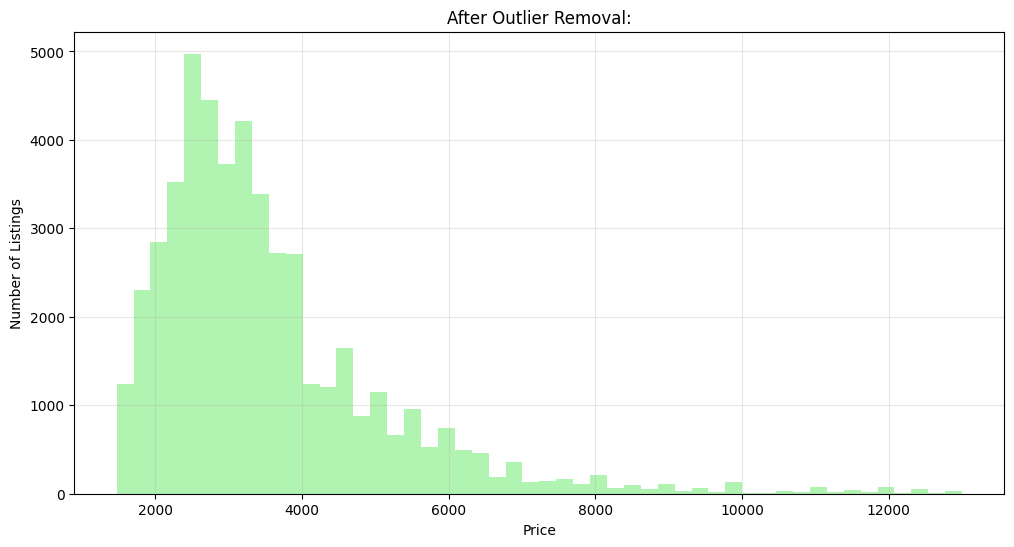

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(features_df_clean['price'], bins=50, alpha=0.7, color='lightgreen')
plt.title('After Outlier Removal:')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.grid(True, alpha=0.3)
plt.show()

What changed? A percentile is a value below which a certain percentage of the data lies. The 1st percentile is the value below which 1% of the data lies. The 99th - below which 99% of the data lies. The 50th - is the median.
I removed the outliers.

What is the data type of the 'interest_level' column?

In [11]:
print(features_df_clean['interest_level'].dtype)

object


I'm displaying the values in this column. How many records does each value contain?

In [12]:
interest_count = features_df_clean['interest_level'].value_counts()
print (interest_count)

interest_level
low       33697
medium    11116
high       3566
Name: count, dtype: int64


We need to encode these values. For example, replace each value with 0, 1, or 2.

In [13]:
features_df_clean['interest_level_encoded'] = features_df_clean['interest_level'].map({
    'low': 0,
    'medium': 1,
    'high': 2
})

print(features_df_clean[['interest_level', 'interest_level_encoded']].head(10))

   interest_level  interest_level_encoded
4          medium                       1
6             low                       0
9          medium                       1
10         medium                       1
15            low                       0
16            low                       0
18            low                       0
19           high                       2
23            low                       0
32            low                       0


Histogram for the features 'bathrooms', 'bedrooms'. Are there any outliers?

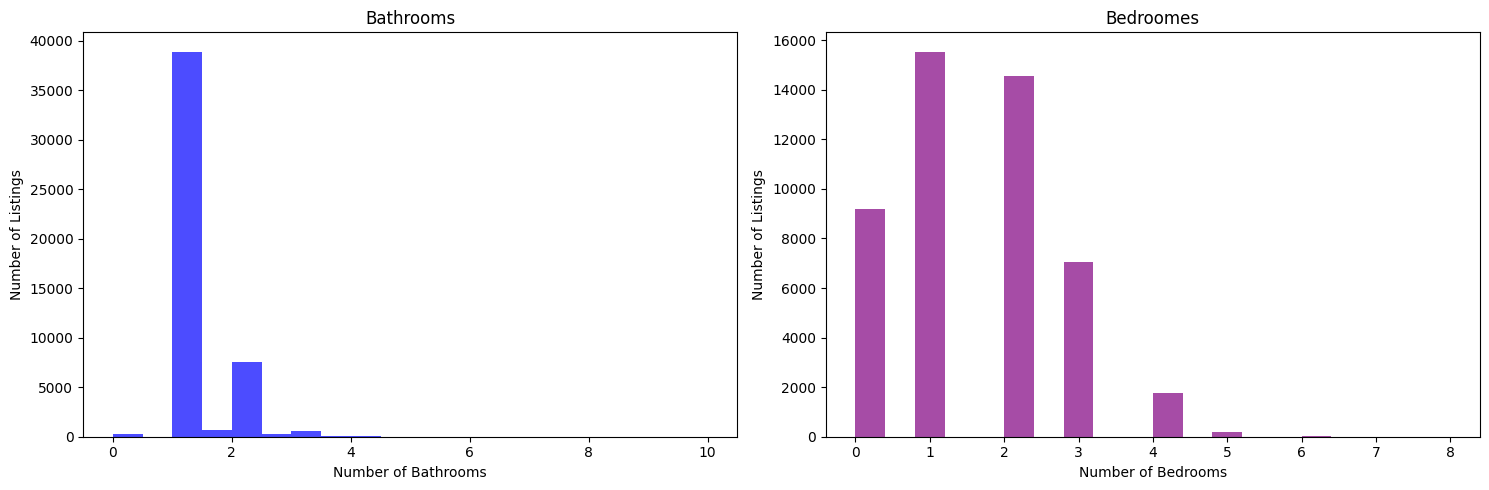

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].hist(features_df_clean['bathrooms'], bins=20, alpha=0.7, color='blue')
axes[0].set_title('Bathrooms')
axes[0].set_xlabel('Number of Bathrooms')
axes[0].set_ylabel('Number of Listings')

axes[1].hist(features_df_clean['bedrooms'], bins=20, alpha=0.7, color='purple')
axes[1].set_title('Bedroomes')
axes[1].set_xlabel('Number of Bedrooms')
axes[1].set_ylabel('Number of Listings')

plt.tight_layout()
plt.show()

Correlation matrix to understand the relationship between features and the target. And we need to make a heatmap for the correlation matrix. Is there a correlation?

In [15]:
corr_matrix = features_df_clean[['bathrooms', 'bedrooms', 'interest_level_encoded', 'price']].corr()
corr_matrix

,bathrooms,bedrooms,interest_level_encoded,price
bathrooms,1.000000,0.517574,-0.063635,0.671943
bedrooms,0.517574,1.000000,0.050654,0.545948
interest_level_encoded,-0.063635,0.050654,1.000000,-0.200111
price,0.671943,0.545948,-0.200111,1.000000


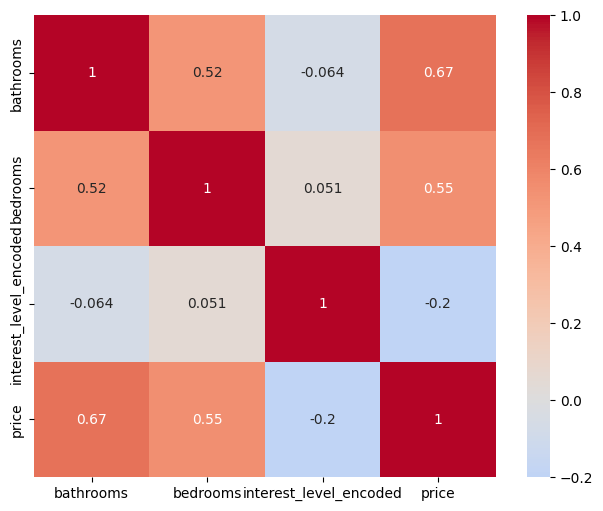

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.show()

The highest correlation is between price and the number of bathrooms.

Now a scatter plot to visualize the relationship between features and the target. I will create 3 plots where the X-axis will be the target and the Y-axis will be the feature.

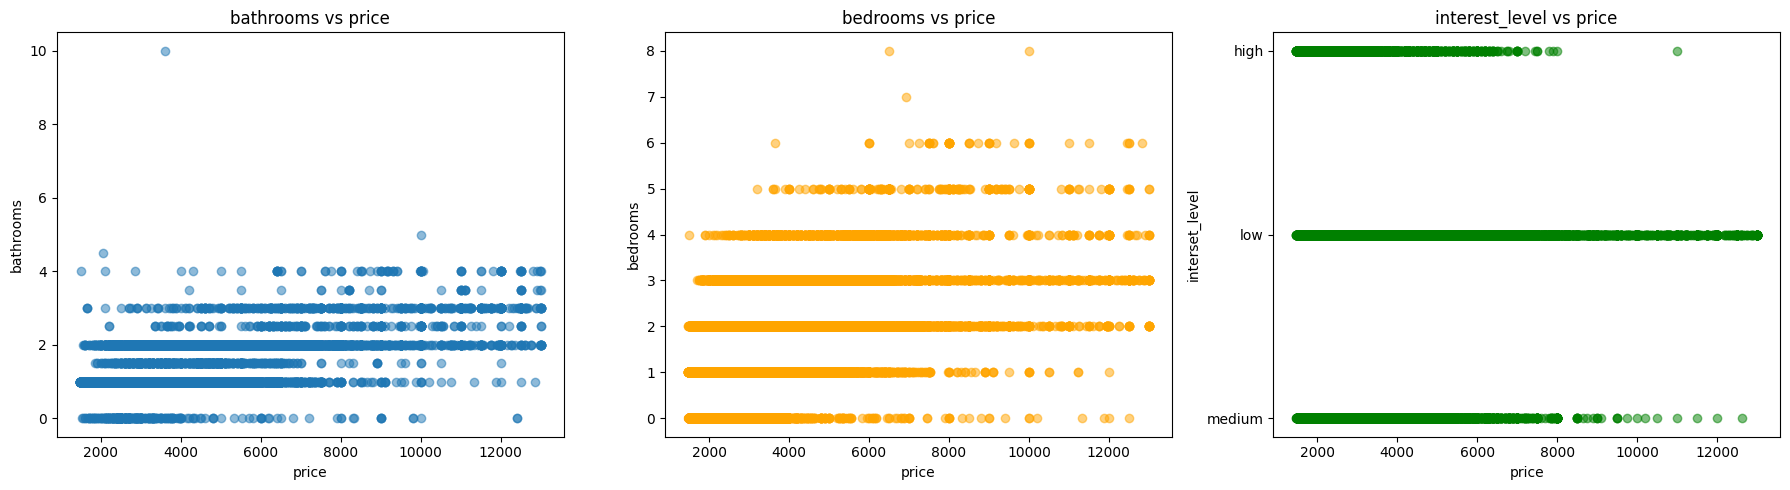

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(features_df_clean['price'], features_df_clean['bathrooms'], alpha=0.5)
axes[0].set_title('bathrooms vs price')
axes[0].set_xlabel('price')
axes[0].set_ylabel('bathrooms')

axes[1].scatter(features_df_clean['price'], features_df_clean['bedrooms'], alpha=0.5, color='orange')
axes[1].set_title('bedrooms vs price')
axes[1].set_xlabel('price')
axes[1].set_ylabel('bedrooms')

axes[2].scatter(features_df_clean['price'], features_df_clean['interest_level'], alpha=0.5, color='green')
axes[2].set_title('interest_level vs price')
axes[2].set_xlabel('price')
axes[2].set_ylabel('interset_level')

plt.tight_layout()
plt.show()

The next step is very extensive. I will create new features. For example, I will add three new features squared: 'bathrooms_squared', 'bedrooms_squared', 'interest_level_squared'. I will build a correlation matrix with the new features. Are the new features more strongly related to the target than the base features?

In [18]:
features_df_clean['bathrooms_squared'] = features_df_clean['bathrooms'] ** 2
features_df_clean['bedrooms_squared'] = features_df_clean['bedrooms'] ** 2
features_df_clean['interest_level_squared'] = features_df_clean['interest_level_encoded'] ** 2

In [19]:
new_corr_matrix = features_df_clean[['bathrooms', 'bathrooms_squared', 'bedrooms', 'bedrooms_squared',
                                     'interest_level_encoded', 'interest_level_squared', 'price']].corr()
new_corr_matrix

,bathrooms,bathrooms_squared,bedrooms,bedrooms_squared,interest_level_encoded,interest_level_squared,price
bathrooms,1.000000,0.956023,0.517574,0.548760,-0.063635,-0.059410,0.671943
bathrooms_squared,0.956023,1.000000,0.478817,0.522227,-0.068558,-0.062240,0.648486
bedrooms,0.517574,0.478817,1.000000,0.928277,0.050654,0.039511,0.545948
bedrooms_squared,0.548760,0.522227,0.928277,1.000000,0.046340,0.035718,0.543406
interest_level_encoded,-0.063635,-0.068558,0.050654,0.046340,1.000000,0.944013,-0.200111
interest_level_squared,-0.059410,-0.062240,0.039511,0.035718,0.944013,1.000000,-0.182672
price,0.671943,0.648486,0.545948,0.543406,-0.200111,-0.182672,1.000000


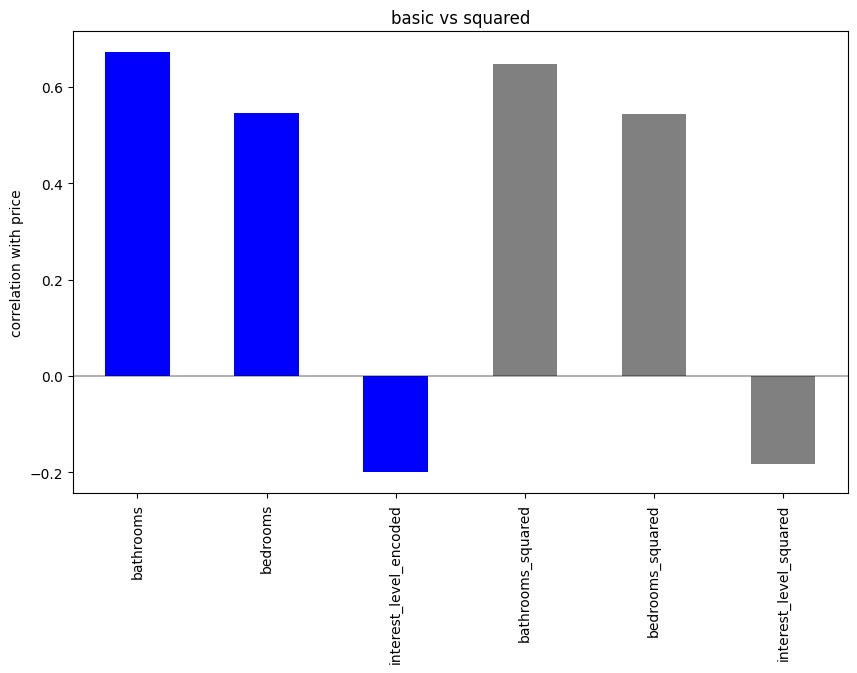

In [20]:
plt.figure(figsize=(10, 6))

basic_corr = corr_matrix.loc[['bathrooms', 'bedrooms', 'interest_level_encoded'], 'price']
new_corr = new_corr_matrix.loc[['bathrooms_squared', 'bedrooms_squared', 'interest_level_squared'], 'price']

all_corr = pd.concat([basic_corr, new_corr])
all_corr.plot(kind='bar', color=['blue', 'blue', 'blue', 'grey', 'grey', 'grey'])
plt.title('basic vs squared')
plt.ylabel('correlation with price')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.show()

It didn't help much. We were looking for non-linear dependencies, but without success.

To use PolynomialFeatures, we first need to split the data into training and test sets. This is already done. I'm initializing PolynomialFeatures() with degree 10.

In [21]:
x_train = features_df_clean[['bathrooms', 'bedrooms']]
y_train = features_df_clean['price']

In [22]:
test_df = pd.read_json('../data/test.json')
test_df.shape

if 'price' in test_df.columns:
    x_test = test_df[['bathrooms', 'bedrooms']]
    y_test = test_df['price']
    print("test.json contains prices for testing")
else:
    x_test = test_df[['bathrooms', 'bedrooms']]
    y_test = None
    print("No prices available")

test.json contains prices for testing


PolynomialFeatures() to fit and transform the training and test data.

In [23]:
poly = PolynomialFeatures(degree=10)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

print(f"Number of features before: {x_train.shape[1]}")
print(f"Number of features after: {x_train_poly.shape[1]}")

Number of features before: 2
Number of features after: 66


I will create two empty Pandas dataframes with columns 'model', 'training', and 'testing'. I will name the first dataframe result_MAE, and the second one result_RMSE. Then I will fill these tables with the results of the models.

In [24]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])  # Mean Absolute Error
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test']) # Root Mean Square Error

In [25]:
p1_test = test_df['price'].quantile(0.01)
p99_test = test_df['price'].quantile(0.99)

test_df_clean = test_df[(test_df['price'] >= p1_test) & (test_df['price'] <= p99_test)].copy()

print(f"Outliers removed: {len(test_df) - len(test_df_clean)}")
print(f"Test data remaining: {len(test_df_clean)}")

Outliers removed: 1443
Test data remaining: 73216


In [26]:
x_train = features_df_clean[['bathrooms', 'bedrooms']]
y_train = features_df_clean['price']

x_test_clean = test_df_clean[['bathrooms', 'bedrooms']]
y_test_clean = test_df_clean['price']

We initialize linear regression from sklearn without parameters.

In [27]:
linear_model = LinearRegression()

I fit the model and make predictions based on training and test data. I will save them as new columns in the data.

In [28]:
linear_model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
y_train_pred = linear_model.predict(x_train)
y_test_pred_clean = linear_model.predict(x_test_clean)

In [30]:
features_df_clean['linear_regression_pred'] = y_train_pred
test_df_clean['linear_regression_pred'] = y_test_pred_clean

MAE for training and test data.

In [31]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test_clean, y_test_pred_clean)

print(f"MAE on training data: {train_mae:.2f}")
print(f"MAE on test data: {test_mae:.2f}")

MAE on training data: 784.56
MAE on test data: 790.48


RMSE  for training and test data.

In [32]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_clean))

print(f"RMSE on training data: {train_rmse:.2f}")
print(f"RMSE on test data: {test_rmse:.2f}")

RMSE on training data: 1123.88
RMSE on test data: 1368.57


We insert the metrics into the result_MAE and result_RMSE tables with the model name "linear regression".

In [33]:
result_MAE.loc[0] = ['linear_regression', train_mae, test_mae]
result_RMSE.loc[0] = ['linear_regression', train_rmse, test_rmse]

I initialize a decision tree from sklearn with a fixed random_state=21.

In [34]:
tree_model = DecisionTreeRegressor(random_state=21)

I fit it to the training features and target function and make a prediction based on the training and test features. I will save it as a new column in the data.

In [35]:
tree_model.fit(x_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,21
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [36]:
tree_model = DecisionTreeRegressor(random_state=21)
tree_model.fit(x_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,21
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [37]:
y_train_pred_tree = tree_model.predict(x_train)
y_test_pred_tree_clean = tree_model.predict(x_test_clean)

In [38]:
features_df_clean['decision_tree_pred'] = y_train_pred_tree
test_df_clean['decision_tree_pred'] = y_test_pred_tree_clean

MAE

In [39]:
train_mae_tree = mean_absolute_error(y_train, y_train_pred_tree)
test_mae_tree = mean_absolute_error(y_test_clean, y_test_pred_tree_clean)

print(f"MAE on training data: {train_mae_tree:.2f}")
print(f"MAE on test data: {test_mae_tree:.2f}")

MAE on training data: 756.04
MAE on test data: 759.29


RMSE

In [40]:
train_rmse_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
test_rmse_tree = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_tree_clean))

print(f"RMSE on training data: {train_rmse_tree:.2f}")
print(f"RMSE on test data: {test_rmse_tree:.2f}")

RMSE on training data: 1077.48
RMSE on test data: 1081.05


We insert the metrics into the result_MAE and result_RMSE tables with the model name "decision tree".

In [41]:
result_MAE.loc[1] = ['decision_tree', train_mae_tree, test_mae_tree]
result_RMSE.loc[1] = ['decision_tree', train_rmse_tree, test_rmse_tree]

Let's calculate the mean and median for the 'price' parameter in the training and test data and create a column with these values.

In [42]:
mean_price = y_train.mean()
median_price = y_train.median()

print(f"Average price in training data: {mean_price:.2f}")
print(f"Median price in training data: {median_price:.2f}")

Average price in training data: 3538.64
Median price in training data: 3150.00


In [43]:
y_train_pred_mean = [mean_price] * len(y_train)
y_test_pred_mean_clean = [mean_price] * len(y_test_clean)

y_train_pred_median = [median_price] * len(y_train)
y_test_pred_median_clean = [median_price] * len(y_test_clean)

print(f"naive_mean: always predict {mean_price:.0f}")
print(f"naive_median: always predict {median_price:.0f}")

naive_mean: always predict 3539
naive_median: always predict 3150


In [44]:
features_df_clean['naive_mean_pred'] = y_train_pred_mean
test_df_clean['naive_mean_pred'] = y_test_pred_mean_clean

features_df_clean['naive_median_pred'] = y_train_pred_median  
test_df_clean['naive_median_pred'] = y_test_pred_median_clean

MAE for training and test targets between the target and the calculated mean and median.

In [45]:
# for mean

train_mae_mean = mean_absolute_error(y_train, y_train_pred_mean)
test_mae_mean = mean_absolute_error(y_test_clean, y_test_pred_mean_clean)
train_rmse_mean = np.sqrt(mean_squared_error(y_train, y_train_pred_mean))
test_rmse_mean = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_mean_clean))

print("naive_mean:")
print(f"MAE: train={train_mae_mean:.2f}, test={test_mae_mean:.2f}")
print(f"RMSE: train={train_rmse_mean:.2f}, test={test_rmse_mean:.2f}")

naive_mean:
MAE: train=1139.19, test=1137.34
RMSE: train=1597.65, test=1590.10


In [46]:
result_MAE.loc[2] = ['naive_mean', train_mae_mean, test_mae_mean]
result_RMSE.loc[2] = ['naive_mean', train_rmse_mean, test_rmse_mean]

RMSE

In [47]:
# for naive_median
train_mae_median = mean_absolute_error(y_train, y_train_pred_median)
test_mae_median = mean_absolute_error(y_test_clean, y_test_pred_median_clean)
train_rmse_median = np.sqrt(mean_squared_error(y_train, y_train_pred_median))
test_rmse_median = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_median_clean))

print("naive_median:")
print(f"MAE: train={train_mae_median:.2f}, test={test_mae_median:.2f}")
print(f"RMSE: train={train_rmse_median:.2f}, test={test_rmse_median:.2f}")

naive_median:
MAE: train=1086.21, test=1084.27
RMSE: train=1644.24, test=1635.38


In [48]:
result_MAE.loc[3] = ['naive_median', train_mae_median, test_mae_median]
result_RMSE.loc[3] = ['naive_median', train_rmse_median, test_rmse_median]

Final tables result_MAE и result_RMSE.

In [49]:
print("result_MAE:")
result_MAE

result_MAE:


,model,train,test
0,linear_regression,784.563837,790.478922
1,decision_tree,756.044735,759.294165
2,naive_mean,1139.192515,1137.339895
3,naive_median,1086.210505,1084.274571


In [50]:
print("result_RMSE:")
result_RMSE

result_RMSE:


,model,train,test
0,linear_regression,1123.877748,1368.570772
1,decision_tree,1077.483596,1081.050194
2,naive_mean,1597.646655,1590.102981
3,naive_median,1644.236439,1635.375966


Which model is better?

Decision Tree